# UCI Heart Disease (Cleveland) — Small Bayesian Network (pgmpy 0.1.24)

**Goal.** Build a compact Bayesian Network to model the dependency of **Heart Disease** on a few features, then perform inference $P(\text{disease} \mid \text{evidence})$.

**Why this version?** Windows users sometimes hit DLL errors via Torch when using newer BN toolchains. This notebook pins to **pgmpy==0.1.24** (no Torch dependency) and a compatible **networkx==2.8.8** to be robust.

**Plan.**
1) Bootstrap environment (installs specific versions in-notebook)
2) Load & clean Cleveland subset
3) Discretize features and binarize target
4) Define a compact BN structure and fit CPDs (MLE)
5) Visualize the network graph (PNG)
6) Inference: compute $P(\text{disease}=1 \mid \text{evidence})$ for scenarios and save a table


In [1]:
import sys, subprocess

def pip_run(args):
    subprocess.check_call([sys.executable, "-m", "pip", *args])

# Remove potentially conflicting packages (ignore failures)
for pkg in ["pomegranate", "pgmpy", "torch", "torchvision", "torchaudio"]:
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "uninstall", "-y", pkg])
    except Exception:
        pass

# Install exact versions we want
pip_run(["install", "pgmpy==0.1.24", "networkx==2.8.8", "pandas", "numpy", "matplotlib"])  

# Imports using the pinned versions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pathlib import Path

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

import pgmpy, networkx
print("pgmpy:", pgmpy.__version__, "networkx:", networkx.__version__)
plt.rcParams["figure.dpi"] = 140


c:\Users\Dell\miniconda3\envs\tfenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pgmpy: 0.1.24 networkx: 2.8.8


## 1) Load Cleveland subset & clean

- Source file: `processed.cleveland.data` (UCI repository).
- Handle missing values marked as `'?'`.
- Keep a minimal feature set for this BN: `age`, `trestbps` (resting BP), `cp` (chest pain type), and target `num` (binarized to `disease`).


In [2]:
cols = [
    "age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang",
    "oldpeak","slope","ca","thal","num"
]
uci_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

data_dir = Path("data"); data_dir.mkdir(parents=True, exist_ok=True)
local_path = data_dir / "processed.cleveland.data"

def load_cleveland():
    import pandas as pd
    try:
        df = pd.read_csv(uci_url, header=None, names=cols, na_values="?")
        print("Loaded from UCI URL.")
        df.to_csv(local_path, index=False)
    except Exception as e:
        print(f"URL load failed: {e}\nTrying local file: {local_path}")
        df = pd.read_csv(local_path, header=0, names=cols, na_values="?")
    return df

df_raw = load_cleveland()
print("Raw shape:", df_raw.shape)
df_raw.head()


Loaded from UCI URL.
Raw shape: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


## 2) Preprocess & discretize

- **Target:** `disease = 1` if `num > 0`, else `0`.
- **Features:**
  - `cp` (chest pain type): keep as categorical (1–4), with readable labels.
  - `age`, `trestbps`: discretize into 4 bins (quantiles) for a discrete BN.

We drop rows with missing values **in the selected columns** to keep the example simple.


In [3]:
df = df_raw.copy()

# Target: 0 vs 1 (presence of disease)
df["disease"] = (df["num"] > 0).astype(int)

# Keep only selected columns
keep_cols = ["age", "trestbps", "cp", "disease"]
df = df[keep_cols].dropna()

# Map chest pain codes to readable labels
cp_map = {1: "typical", 2: "atypical", 3: "nonanginal", 4: "asymptomatic"}
df["cp"] = df["cp"].astype(int).map(cp_map)

# Discretize continuous columns using quartiles (equal-frequency bins)
def qbin(s, q=4, prefix=""):
    cats, bins = pd.qcut(s, q=q, duplicates="drop", retbins=True)
    labels = [f"{prefix}{i+1}" for i in range(len(bins)-1)]
    cats = pd.qcut(s, q=len(labels), labels=labels, duplicates="drop")
    return cats.astype(str), bins

df["age_bin"], age_bins = qbin(df["age"], q=4, prefix="ageQ")
df["trestbps_bin"], bp_bins = qbin(df["trestbps"], q=4, prefix="bpQ")

bn_df = df[["age_bin","trestbps_bin","cp","disease"]].dropna().reset_index(drop=True)
print("After preprocessing:", bn_df.shape)
bn_df.head(8)


After preprocessing: (303, 4)


,age_bin,trestbps_bin,cp,disease
0,ageQ4,bpQ4,typical,0
1,ageQ4,bpQ4,asymptomatic,1
2,ageQ4,bpQ1,asymptomatic,1
3,ageQ1,bpQ2,nonanginal,0
4,ageQ1,bpQ2,atypical,0
5,ageQ2,bpQ1,atypical,0
6,ageQ4,bpQ3,asymptomatic,1
7,ageQ3,bpQ1,asymptomatic,0


## 3) Define BN structure & learn CPDs (MLE)

Compact, interpretable structure:

- `age_bin → trestbps_bin`
- `age_bin → disease`
- `cp → disease`
- `trestbps_bin → disease`

Fit **CPDs** via Maximum Likelihood Estimation on the discretized data.


In [4]:
model = BayesianNetwork([
    ("age_bin","trestbps_bin"),
    ("age_bin","disease"),
    ("cp","disease"),
    ("trestbps_bin","disease"),
])

model.fit(bn_df, estimator=MaximumLikelihoodEstimator)
model.check_model()
print("Model edges:", model.edges())

for cpd in model.get_cpds():
    print("\n", cpd)


Model edges: [('age_bin', 'trestbps_bin'), ('age_bin', 'disease'), ('trestbps_bin', 'disease'), ('cp', 'disease')]

 +----------------+----------+
| age_bin(ageQ1) | 0.270627 |
+----------------+----------+
| age_bin(ageQ2) | 0.264026 |
+----------------+----------+
| age_bin(ageQ3) | 0.231023 |
+----------------+----------+
| age_bin(ageQ4) | 0.234323 |
+----------------+----------+

 +--------------------+-----+---------------------+
| age_bin            | ... | age_bin(ageQ4)      |
+--------------------+-----+---------------------+
| trestbps_bin(bpQ1) | ... | 0.2676056338028169  |
+--------------------+-----+---------------------+
| trestbps_bin(bpQ2) | ... | 0.18309859154929578 |
+--------------------+-----+---------------------+
| trestbps_bin(bpQ3) | ... | 0.19718309859154928 |
+--------------------+-----+---------------------+
| trestbps_bin(bpQ4) | ... | 0.352112676056338   |
+--------------------+-----+---------------------+

 +--------------+--------------------+-----+-----

## 4) Visualize the network graph

We draw the DAG and save it as `figures/heart_bn_graph.png`. Include this PNG (or a screenshot) in your submission.


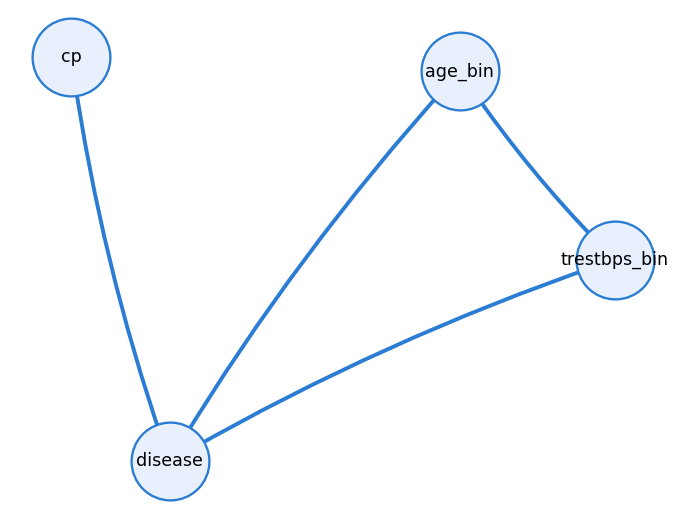

Saved graph to C:\Users\Dell\Desktop\Group_2\Week5_bayes_rl\figures\heart_bn_graph.png


In [8]:
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt

fig_dir = Path("figures"); fig_dir.mkdir(parents=True, exist_ok=True)

# Convert pgmpy model to a plain DiGraph
G = nx.DiGraph()
G.add_nodes_from(model.nodes())
G.add_edges_from(model.edges())

plt.figure(figsize=(5.0, 3.8))
pos = nx.spring_layout(G, seed=42)  # or try nx.shell_layout(G) if you prefer

# Draw in three steps (nodes, edges, labels) to avoid ArrowPatch quirks
nx.draw_networkx_nodes(G, pos, node_color="#e8f0fe", node_size=1600, edgecolors="#2b7cd3", linewidths=1.2)
nx.draw_networkx_edges(G, pos, arrows=True, width=2.0, edge_color="#2b7cd3", connectionstyle="arc3,rad=0.05")
nx.draw_networkx_labels(G, pos, font_size=9)

plt.axis("off")
out_path = fig_dir / "heart_bn_graph.png"
plt.tight_layout()
plt.savefig(out_path, dpi=200)
plt.show()
print(f"Saved graph to {out_path.resolve()}")


## 5) Inference: $ P(\text{disease} \mid \text{evidence}) $

Run **Variable Elimination** for several evidence assignments and tabulate  
$ P(\text{disease}=1 \mid \text{evidence}) $. Evidence uses our **discretized** features:

- `age_bin ∈ {ageQ1, ageQ2, ageQ3, ageQ4}`
- `trestbps_bin ∈ {bpQ1, bpQ2, bpQ3, bpQ4}`
- `cp ∈ {typical, atypical, nonanginal, asymptomatic}`


In [9]:
infer = VariableElimination(model)

def p_disease1(evidence: dict) -> float:
    q = infer.query(variables=["disease"], evidence=evidence, show_progress=False)
    # 'disease' is binary {0,1}; index 1 corresponds to presence
    return float(q.values[1])

scenarios = [
    {"name": "Younger & low BP, non-anginal pain",
     "evidence": {"age_bin":"ageQ1", "trestbps_bin":"bpQ1", "cp":"nonanginal"}},
    {"name": "Older & high BP, asymptomatic",
     "evidence": {"age_bin":"ageQ4", "trestbps_bin":"bpQ4", "cp":"asymptomatic"}},
    {"name": "Mid-age, moderate BP, atypical",
     "evidence": {"age_bin":"ageQ3", "trestbps_bin":"bpQ3", "cp":"atypical"}},
    {"name": "Older, moderate BP, typical angina",
     "evidence": {"age_bin":"ageQ4", "trestbps_bin":"bpQ2", "cp":"typical"}},
]

rows = []
for s in scenarios:
    prob = p_disease1(s["evidence"])
    rows.append({
        "scenario": s["name"],
        "evidence": s["evidence"],
        "P(disease=1 | evidence)": round(prob, 3)
    })

inf_df = pd.DataFrame(rows)
inf_df


,scenario,evidence,P(disease=1 | evidence)
0,"Younger & low BP, non-anginal pain","{'age_bin': 'ageQ1', 'trestbps_bin': 'bpQ1', '...",0.100
1,"Older & high BP, asymptomatic","{'age_bin': 'ageQ4', 'trestbps_bin': 'bpQ4', '...",0.818
2,"Mid-age, moderate BP, atypical","{'age_bin': 'ageQ3', 'trestbps_bin': 'bpQ3', '...",0.500
3,"Older, moderate BP, typical angina","{'age_bin': 'ageQ4', 'trestbps_bin': 'bpQ2', '...",0.500


### Save inference table


In [10]:
out_dir = Path("outputs"); out_dir.mkdir(parents=True, exist_ok=True)
inff = out_dir / "heart_bn_inference_table.csv"
inf_df.to_csv(inff, index=False)
print(f"Saved inference table to {inff.resolve()}")


Saved inference table to C:\Users\Dell\Desktop\Group_2\Week5_bayes_rl\outputs\heart_bn_inference_table.csv


## 6) Short interpretation (paste into your report)

> We built a compact Bayesian Network on the Cleveland subset using three predictors—discretized **age** and **resting blood pressure**, and categorical **chest pain type (cp)**—with **disease** as the target (binarized from `num`). We specified a simple DAG reflecting plausible dependencies (`age→trestbps`, plus all three into `disease`) and estimated CPDs by maximum likelihood on the discretized data. Using Variable Elimination, we computed $P(\text{disease}=1\mid\text{evidence})$ for several clinical scenarios. As expected, evidence such as **older age**, **higher resting BP**, and **asymptomatic chest pain** increased the inferred risk compared with younger/low-BP/non-anginal presentations. The graph (`figures/heart_bn_graph.png`) and the inference table quantify these effects.
